In [110]:
import json

# Provided data
data = {"username":"uom200088d","key":"b8a8f1354ecced4d47d7e80e628e11f0"}

# Write data to kaggle.json
with open('kaggle.json', 'w') as file:
    json.dump(data, file)

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c store-sales-time-series-forecasting
import zipfile

# Create a ZipFile Object
with zipfile.ZipFile('store-sales-time-series-forecasting.zip') as zip_obj:
   # Extract all the contents of zip file to current directory
   zip_obj.extractall('store_sales_data')

%cd store_sales_data

 80% 17.0M/21.4M [00:00<00:00, 65.2MB/s]
100% 21.4M/21.4M [00:00<00:00, 70.8MB/s]
/content/store_sales_data/store_sales_data


In [111]:
!pip install darts

In [112]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [113]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])

oil = pd.read_csv("oil.csv", parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv("stores.csv")
transaction = pd.read_csv("transactions.csv", parse_dates=["date"])
holiday = pd.read_csv("holidays_events.csv", parse_dates=["date"])

In this problem, our target series for forecasting is the sales column for the Ecuadorian-based grocery retailer. With 54 stores present, each having 33 types of products sold, this amounts to 1782 target series for forecasting. We can check that there are missing gaps (4 missing dates) in our target series, which we will investigate next.

=========================
Basic information of data
=========================
Number of family types      : 33
Number of stores            : 54
Number of store-family pairs: 1782
Number of target series     : 1782

Number of unique train dates: 1684
Train date range            : 1688 days from 2013-01-01 to 2017-08-15
Number of unique test dates : 16
Test date range             : 16 days from 2017-08-16 to 2017-08-31

===========================
Missing gaps in time series
===========================
List incl. unique counts of data points: [1684]
Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

In [114]:
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1

It turns out that all the target series have missing dates on Christmas across the years, which suggests that the stores could be closed on this day.

===========================
Missing gaps in time series
===========================
List incl. unique counts of data points: [1684]
Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

In [115]:
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [116]:
# reindex training data
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train.id = train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

=================
Missing oil dates
=================
Number of missing oil dates: 486
Number of weekends missing : 486
Total number of weekends   : 486

Because our grocery stores open on weekends as well, there is a need to estimate the missing oil prices if we are to use them in our models. For simplicity, we fill the missing values in the oil column using linear interpolation.

In [117]:
# reindex oil data
oil = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
oil.oil = oil.oil.interpolate(method="linear", limit_direction="both")

With 54 stores and 1688 training dates, we should have a total of 91152 records of transaction. However, this does not tally with the dataset given. We can easily check that the transaction data does not record days with zero sales, indicating that such days are generally not recorded. As such, for days with zero sales, we fill the transactions column with 0s.

After doing that, we observe that there are still missing values, suggesting that there are indeed missing data entries not due to zero sales. For simplicity, we fill the remaining missing values using linear interpolation.


===========================
Missing transaction records
===========================
Correct number of records: 91152

Breakdown...
Current number of records: 83488
Number of zero sales     : 7546
Number of missing records: 118

In [118]:
# compute total sales for each store
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
transaction.loc[transaction.sales.eq(0), "transactions"] = 0.
transaction = transaction.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
transaction.transactions = transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

=====================================
List of locale names for each holiday
=====================================
Locale names for national holidays:
['Ecuador']

Locale names for regional holidays:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

Locale names for local holidays:
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']

It turns out that there are other examples, such as the Independence Day for the different cities. For simplicity, we assume that such holidays should have similar impacts on the store sales. We assign the same labels for such holidays by removing extra words like bridge (puente) and the city/state names from the description column. The function to process the column is given below.


In [119]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(store.city.str.lower()) | set(store.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [120]:
holiday.description = holiday.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""),
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


We further process the holiday data by removing holidays which are transferred. This can be checked using the transferred column. Since the holidays are not celebrated during the official date and are more like normal days, we exclude them.

We then separate them into national/regional/local holidays, and Saturdays that are designated as work days. Prefixes nat_ / loc_ are set for national/local holidays to better differentiate them during visualization later. For regional holidays, it turns out that we only have provincialization, so it is being labeled as such. An example is shown below, where the national holidays are being encoded as dummy variables. The same applies for the other holidays.


In [121]:
# remove transferred holidays
holiday = holiday[holiday.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = holiday[holiday.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
holiday = holiday[holiday.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = holiday[holiday.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = holiday[holiday.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = holiday[holiday.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Now that we are done with our analysis, we proceed to train our models for forecasting. To prepare our data for training, we need to combine the relevant datasets and include the useful covariates as discussed previously. The steps taken are documented in the code below.

An additional step performed here is that for Christmas and New Year's Day, where most stores have zero sales (as they are likely closed), instead of filling the values with 0s, we temporarily set them to NaN and perform linear interpolation later. The reason for this is to treat such days as regular holidays, instead of having to include an additional variable to capture this unique behavior of store closure.


In [122]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "nat_terremoto", "nat_navidad", "nat_dia la madre", "nat_dia trabajo",
    "nat_primer dia ano", "nat_futbol", "nat_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]

# combine all the datasets
data = pd.concat(
    [train, test], axis=0, ignore_index=True,
).merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    work_days, on="date", how="left",
).merge(
    keep_national_holidays, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

# fill columns with 0s to indicate absence of holidays/events
data[["work_day", *selected_holidays]] = data[["work_day", *selected_holidays]].fillna(0)

# include date-related future covariates
data["day"] = data.date.dt.day
data["month"] = data.date.dt.month
data["year"] = data.date.dt.year
data["day_of_week"] = data.date.dt.dayofweek
data["day_of_year"] = data.date.dt.dayofyear
data["week_of_year"] = data.date.dt.isocalendar().week.astype(int)
data["date_index"] = data.date.factorize()[0] # sort by date above before computing this

# to impute days with zero sales using linear interpolation later
zero_sales_dates = missing_dates + [f"{j}-01-01" for j in range(2013, 2018)]
data.loc[(data.date.isin(zero_sales_dates))&(data.sales.eq(0))&(data.onpromotion.eq(0)), ["sales", "onpromotion"]] = np.nan

# add prefixes for clarity
data.store_nbr = data.store_nbr.apply(lambda x: (f"store_nbr_{x}"))
data.cluster = data.cluster.apply(lambda x: (f"cluster_{x}"))
data.type = data.type.apply(lambda x: (f"type_{x}"))

# add prefixes to ensure no duplicate values between 'city' and 'state'
data.city = data.city.apply(lambda x: (f"city_{x.lower()}"))
data.state = data.state.apply(lambda x: (f"state_{x.lower()}"))

data.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


In [123]:
data

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036523,2017-08-31,store_nbr_54,POULTRY,3029263.0,NaN,0.0,NaN,47.26,city_el carmen,state_manabi,...,0.0,0.0,0.0,31,8,2017,3,243,35,1703
3036524,2017-08-31,store_nbr_54,PREPARED FOODS,3029264.0,NaN,0.0,NaN,47.26,city_el carmen,state_manabi,...,0.0,0.0,0.0,31,8,2017,3,243,35,1703
3036525,2017-08-31,store_nbr_54,PRODUCE,3029265.0,NaN,1.0,NaN,47.26,city_el carmen,state_manabi,...,0.0,0.0,0.0,31,8,2017,3,243,35,1703
3036526,2017-08-31,store_nbr_54,SCHOOL AND OFFICE SUPPLIES,3029266.0,NaN,0.0,NaN,47.26,city_el carmen,state_manabi,...,0.0,0.0,0.0,31,8,2017,3,243,35,1703


In [124]:
data.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'city', 'state', 'type', 'cluster', 'work_day',
       'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo',
       'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'day', 'month',
       'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index'],
      dtype='object')

In [125]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Assuming df is your DataFrame
df = data

# Select columns to transform
cols_to_transform = ['sales', 'onpromotion']

# Fill missing values with linear interpolation
df[cols_to_transform] = df[cols_to_transform].interpolate(method='linear')

In [126]:
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,NaN,NaN,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


In [127]:
df.fillna(0, inplace=True)

In [128]:
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,city,state,...,nat_primer dia ano,nat_futbol,nat_dia difuntos,day,month,year,day_of_week,day_of_year,week_of_year,date_index
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,city_quito,state_pichincha,...,1.0,0.0,0.0,1,1,2013,1,1,1,0


In [129]:
df.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'city', 'state', 'type', 'cluster', 'work_day',
       'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo',
       'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos', 'day', 'month',
       'year', 'day_of_week', 'day_of_year', 'week_of_year', 'date_index'],
      dtype='object')

In [130]:
df[['work_day']]

,work_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3036523,0.0
3036524,0.0
3036525,0.0
3036526,0.0


In [131]:
df = df[['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'type', 'work_day',
       'nat_terremoto', 'nat_navidad', 'nat_dia la madre', 'nat_dia trabajo',
       'nat_primer dia ano', 'nat_futbol', 'nat_dia difuntos']]

In [132]:
df.tail()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,type,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos
3036523,2017-08-31,store_nbr_54,POULTRY,3029263.0,3.0,0.0,0.0,47.26,type_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036524,2017-08-31,store_nbr_54,PREPARED FOODS,3029264.0,3.0,0.0,0.0,47.26,type_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036525,2017-08-31,store_nbr_54,PRODUCE,3029265.0,3.0,1.0,0.0,47.26,type_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036526,2017-08-31,store_nbr_54,SCHOOL AND OFFICE SUPPLIES,3029266.0,3.0,0.0,0.0,47.26,type_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3036527,2017-08-31,store_nbr_54,SEAFOOD,3029267.0,3.0,0.0,0.0,47.26,type_C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
df = df.sort_values('id')
df

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,type,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035038,2017-08-31,store_nbr_9,POULTRY,3029395.0,3.0,1.0,0.0,47.26,type_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3035039,2017-08-31,store_nbr_9,PREPARED FOODS,3029396.0,3.0,0.0,0.0,47.26,type_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3035040,2017-08-31,store_nbr_9,PRODUCE,3029397.0,3.0,1.0,0.0,47.26,type_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3035041,2017-08-31,store_nbr_9,SCHOOL AND OFFICE SUPPLIES,3029398.0,3.0,9.0,0.0,47.26,type_B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,type,work_day,nat_terremoto,nat_navidad,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,type_D,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [135]:
df = pd.get_dummies(df, columns=['type'])
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,93.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,93.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,93.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,93.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,93.14,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0


In [136]:
df.columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'work_day', 'nat_terremoto', 'nat_navidad',
       'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano',
       'nat_futbol', 'nat_dia difuntos', 'type_type_A', 'type_type_B',
       'type_type_C', 'type_type_D', 'type_type_E'],
      dtype='object')

In [137]:
# Apply log1p transformation to 'sales' and 'onpromotion' columns
df['sales'] = np.log1p(df['sales'])
df['onpromotion'] = np.log1p(df['onpromotion'])


# Reverse log1p transformation for 'sales' and 'onpromotion' columns
# df['sales'] = np.expm1(df['sales'])
# df['onpromotion'] = np.expm1(df['onpromotion'])

In [138]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# List of columns to scale
cols_to_scale = ['sales', 'onpromotion', 'transactions', 'oil']

# Apply scaler to the columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
0,2013-01-01,store_nbr_1,AUTOMOTIVE,0.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
1,2013-01-01,store_nbr_1,BABY CARE,1.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
2,2013-01-01,store_nbr_1,BEAUTY,2.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
3,2013-01-01,store_nbr_1,BEVERAGES,3.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0
4,2013-01-01,store_nbr_1,BOOKS,4.0,0.0,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0


In [139]:
# Create a multi-level dictionary to store DataFrames
data = {}

# Iterate over unique families
for family in df['family'].unique():
    data[family] = {}

    # Get rows for the current family
    family_df = df[df['family'] == family]

    # Iterate over unique store numbers within the current family
    for store_nbr in family_df['store_nbr'].unique():

        # Get rows for the current store number and store in dictionary
        data[family][store_nbr] = family_df[family_df['store_nbr'] == store_nbr]


In [140]:
data['AUTOMOTIVE']['store_nbr_20']

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
627,2013-01-01,store_nbr_20,AUTOMOTIVE,396.0,0.000000,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0
2409,2013-01-02,store_nbr_20,AUTOMOTIVE,2178.0,0.000000,0.0,0.0,0.792965,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4191,2013-01-03,store_nbr_20,AUTOMOTIVE,3960.0,0.000000,0.0,0.0,0.790951,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
5973,2013-01-04,store_nbr_20,AUTOMOTIVE,5742.0,0.000000,0.0,0.0,0.792728,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
7755,2013-01-05,store_nbr_20,AUTOMOTIVE,7524.0,0.000000,0.0,0.0,0.793044,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028245,2017-08-27,store_nbr_20,AUTOMOTIVE,3020886.0,0.118145,0.0,0.0,0.244305,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3030027,2017-08-28,store_nbr_20,AUTOMOTIVE,3022668.0,0.118145,0.0,0.0,0.239370,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3031809,2017-08-29,store_nbr_20,AUTOMOTIVE,3024450.0,0.118145,0.0,0.0,0.240081,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3033591,2017-08-30,store_nbr_20,AUTOMOTIVE,3026232.0,0.118145,0.0,0.0,0.234158,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [141]:
%matplotlib inline

import matplotlib.pyplot as plt

from darts import TimeSeries

In [142]:
data['AUTOMOTIVE']['store_nbr_10'].columns

Index(['date', 'store_nbr', 'family', 'id', 'sales', 'onpromotion',
       'transactions', 'oil', 'work_day', 'nat_terremoto', 'nat_navidad',
       'nat_dia la madre', 'nat_dia trabajo', 'nat_primer dia ano',
       'nat_futbol', 'nat_dia difuntos', 'type_type_A', 'type_type_B',
       'type_type_C', 'type_type_D', 'type_type_E'],
      dtype='object')

In [143]:
data['AUTOMOTIVE']['store_nbr_10'][:-16]

,date,store_nbr,family,id,sales,onpromotion,transactions,oil,work_day,nat_terremoto,...,nat_dia la madre,nat_dia trabajo,nat_primer dia ano,nat_futbol,nat_dia difuntos,type_type_A,type_type_B,type_type_C,type_type_D,type_type_E
297,2013-01-01,store_nbr_10,AUTOMOTIVE,33.0,0.000000,0.0,0.000000,0.792965,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0
2079,2013-01-02,store_nbr_10,AUTOMOTIVE,1815.0,0.118145,0.0,0.154684,0.792965,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
3861,2013-01-03,store_nbr_10,AUTOMOTIVE,3597.0,0.093628,0.0,0.138414,0.790951,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
5643,2013-01-04,store_nbr_10,AUTOMOTIVE,5379.0,0.093628,0.0,0.116043,0.792728,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
7425,2013-01-05,store_nbr_10,AUTOMOTIVE,7161.0,0.000000,0.0,0.151812,0.793044,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999403,2017-08-11,store_nbr_10,AUTOMOTIVE,2992011.0,0.093628,0.0,0.087092,0.267914,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
3001185,2017-08-12,store_nbr_10,AUTOMOTIVE,2993793.0,0.093628,0.0,0.114009,0.263098,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
3002967,2017-08-13,store_nbr_10,AUTOMOTIVE,2995575.0,0.000000,0.0,0.096902,0.258281,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
3004749,2017-08-14,store_nbr_10,AUTOMOTIVE,2997357.0,0.059073,0.0,0.104678,0.253464,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0


In [222]:
df1 = data['AUTOMOTIVE']['store_nbr_40']

# Create a TimeSeries for 'sales'
sales_ts1 = TimeSeries.from_dataframe(df1, 'date', 'sales')

# Create a TimeSeries for covariates
future_covariates_ts = TimeSeries.from_dataframe(df, 'date', ['work_day', 'onpromotion','oil',
                                                       'nat_terremoto', 'nat_navidad', 'nat_dia la madre',
                                                       'nat_dia trabajo', 'nat_primer dia ano', 'nat_futbol',
                                                       'nat_dia difuntos', 'type_type_A', 'type_type_B',
                                                       'type_type_C', 'type_type_D', 'type_type_E'])

past_covariates_ts = TimeSeries.from_dataframe(df, 'date', ['transactions'])



train_series1, test_series1 = sales_ts1[:-16], sales_ts1[-16:]

In [223]:
df2 = data['AUTOMOTIVE']['store_nbr_42']

# Create a TimeSeries for 'sales'
sales_ts2 = TimeSeries.from_dataframe(df2, 'date', 'sales')


train_series2, test_series2 = sales_ts2[:-16], sales_ts2[-16:]

<Axes: xlabel='date'>

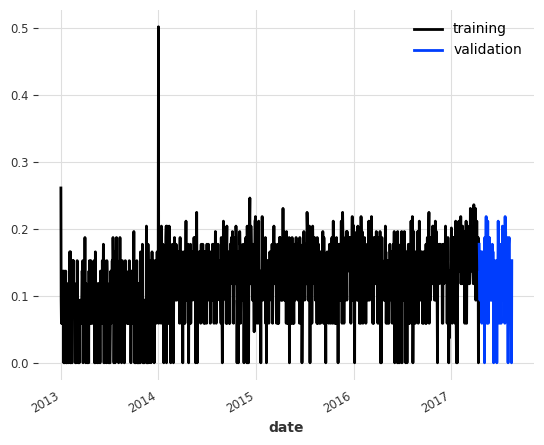

In [224]:
train1, val1 = train_series1.split_before(pd.Timestamp("20170415"))
train1.plot(label="training")
val1.plot(label="validation")

<Axes: xlabel='date'>

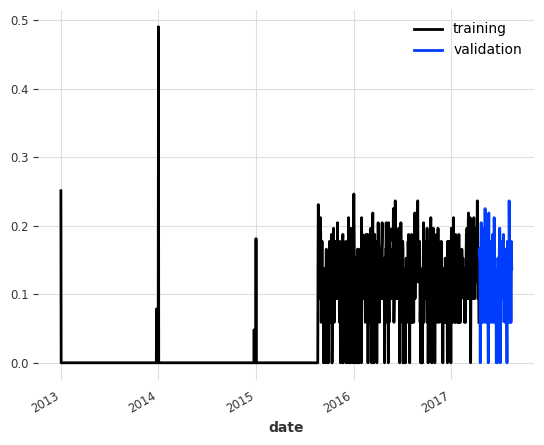

In [225]:
train2, val2 = train_series2.split_before(pd.Timestamp("20170415"))
train2.plot(label="training")
val2.plot(label="validation")

In [230]:
from darts.models import LightGBMModel
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.dataprocessing.transformers import Scaler
def extract_year(idx):
    """Extract the year each time index entry and normalized it."""
    return (idx.year - 2013) / 4


encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "custom": {"past": [extract_year]},
    "transformer": Scaler(),
}
future_lag = 5
past_lag = 15
train = train1.stack(train2)
model = LightGBMModel(lags=20, output_chunk_length=5,add_encoders=encoders, random_state=42,lags_past_covariates=[-16,-17,-18,-19,-20,-21,-22], lags_future_covariates=(14,1), gpu_use_dp= "true")
model.supports_multivariate
model.fit(train,past_covariates=past_covariates_ts, future_covariates=future_covariates_ts);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6895
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 159
[LightGBM] [Info] Start training from score 0.120932
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6895
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 159
[LightGBM] [Info] Start training from score 0.047399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

<Axes: xlabel='date'>

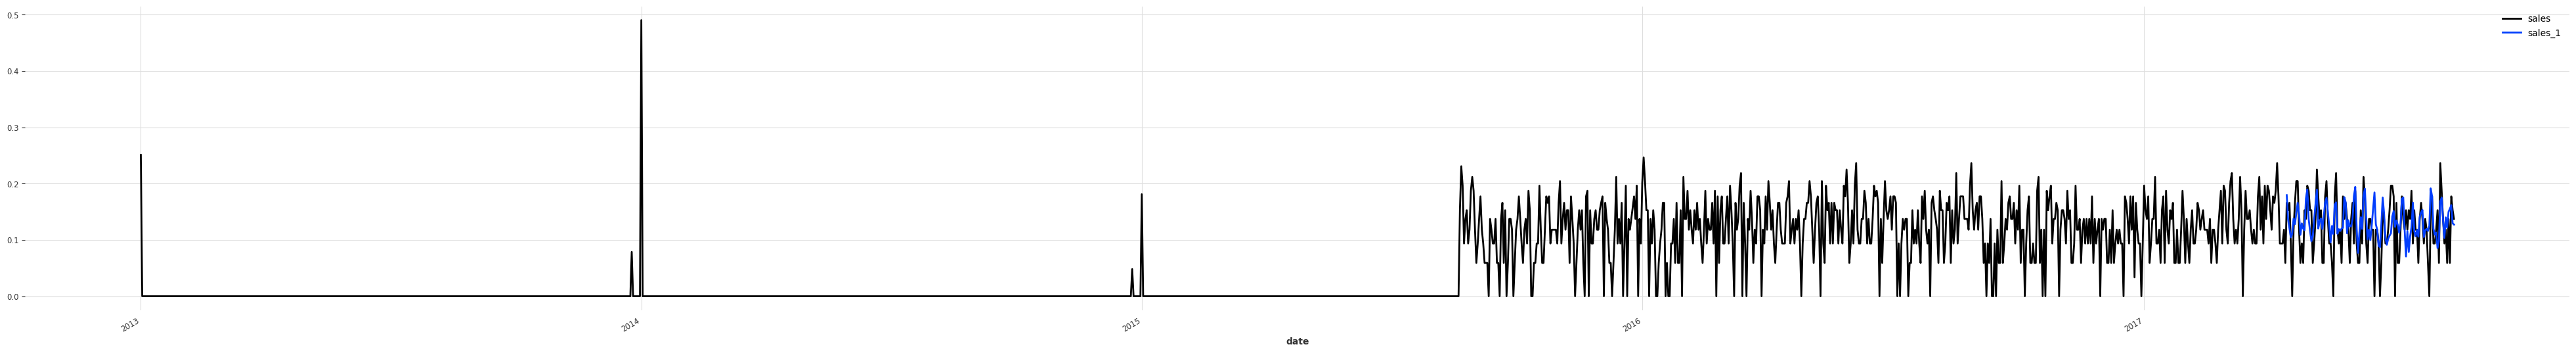

In [238]:
pred1 = model.predict(series=train,past_covariates=past_covariates_ts,future_covariates=future_covariates_ts,n=123)
plt.figure(figsize=(50, 6))
train_series2.plot()
pred1['sales_1'].plot()